In [1]:
dnn_attack_intensity = 9

In [2]:
from models.ae import AE
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN
from models.dnnAE import DNN as DNNAE


import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat
from matplotlib.ticker import FormatStrFormatter

In [3]:
seed = 41
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [5]:
# vae parameter
latent_dim = 118
# rnn parameter
hidden_size = 100
num_layers = 2
rnn_window = 10
# proposed model parameter
samples = 30
# ae parameter
no_residuals = 1

# predictions
pred = defaultdict(dict)
y = defaultdict()
no_signal = defaultdict()

# **DNN Data Generation**

## **Load Sensor and Residual Data**

In [6]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']

Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


## **Load Trained Models**

In [7]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns, aes = dict(), dict(), dict()
# load vae, rnn, ae trained model based on noise levels
for level in noise_levels:
    vae = VAE(latent_dim).to(device)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

    ae = AE(latent_dim).to(device)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

# load dnn and dnnAE trained using normal data and attack severity dnn_attack_intensity attack data
dnn = DNN().to(device)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_attack_intensity}.pt')))

dnnAE = DNNAE(no_residuals=no_residuals).to(device)
dnnAE.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **VAE+RNN --> DNN Data Generation**

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **Normal Sensor Data To DNN Data**

In [9]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z).cpu().detach().numpy()
        s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


### **Attack Sensor Data To DNN Data**

In [10]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z).cpu().detach().numpy()
                s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred['vae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [05:20<00:00, 64.01s/it]


### **Target Data**

In [11]:
_y = []
no_signal['vae'] = len(Z[0]) - rnn_window
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['vae']), dtype=torch.long), num_classes=4))
y['vae'] = torch.cat(_y, dim=0)

## **AE --> DNN Data Generation**

### **Normal Sensor Data To DNN Data**

In [12]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnnAE(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 589.27it/s]


### **Attack Sensor Data To DNN Data**

In [13]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnnAE(torch.cat(list(R.values()), dim=0).to(device))
        pred['ae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


### **Target Data**

In [14]:
_y = []
no_signal['ae'] = len(Z[0])
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['ae']), dtype=torch.long), num_classes=4))
y['ae'] = torch.cat(_y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999696  1.000000  0.999848      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.982666  1.000000  0.991257      3288
           3   1.000000  0.982664  0.991256      3288

    accuracy                       0.995514     13152
   macro avg   0.995590  0.995514  0.995514     13152
weighted avg   0.995590  0.995514  0.995514     13152

Confusion Matrix:


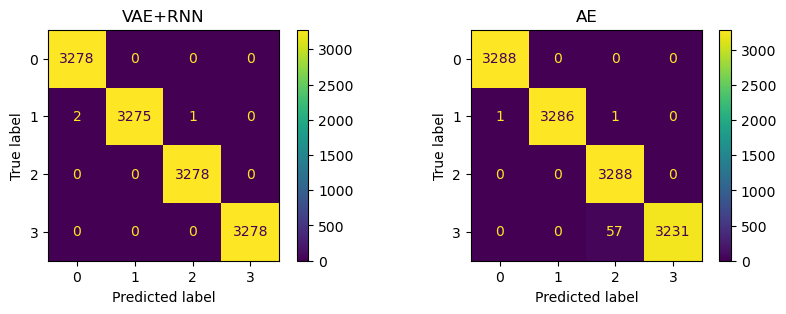

ROC Curve:


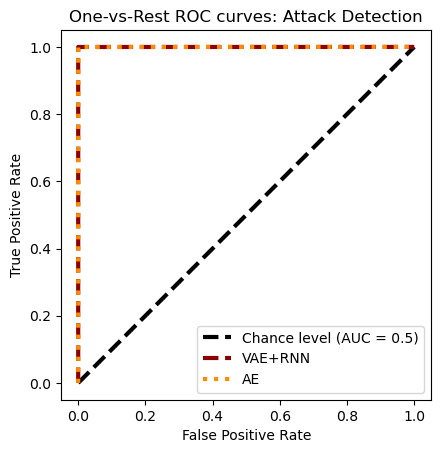

In [15]:
severity = 5
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       1.000000     13112
   macro avg   1.000000  1.000000  1.000000     13112
weighted avg   1.000000  1.000000  1.000000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.997573  1.000000  0.998785      3288
           3   1.000000  0.997567  0.998782      3288

    accuracy                       0.999392     13152
   macro avg   0.999393  0.999392  0.999392     13152
weighted avg   0.999393  0.999392  0.999392     13152

Confusion Matrix:


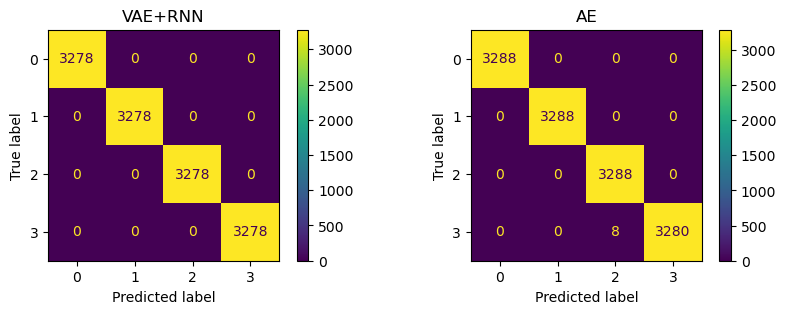

ROC Curve:


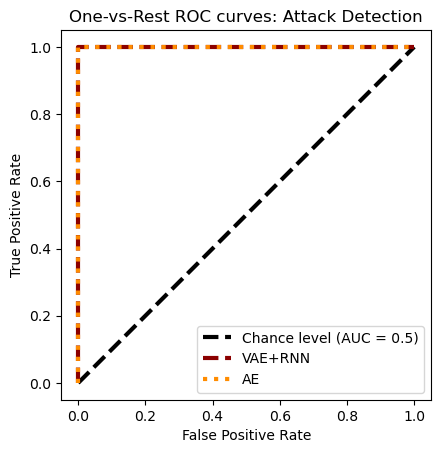

In [16]:
severity = 6
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999695  1.000000  0.999847      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.999695  0.999847      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


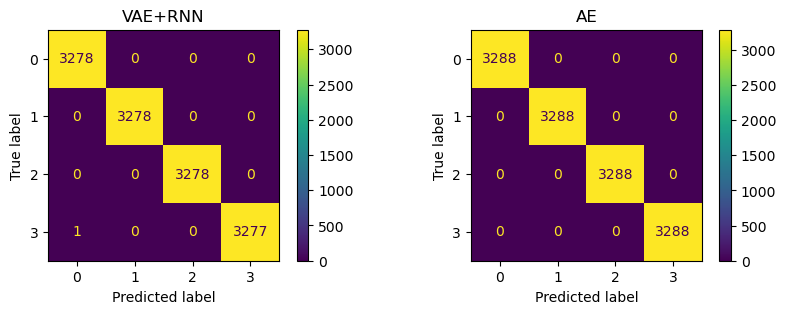

ROC Curve:


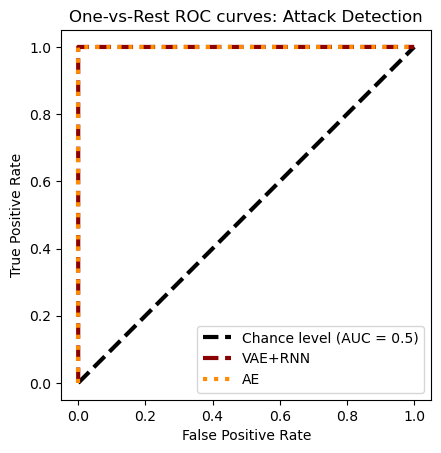

In [17]:
severity = 7
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999086  1.000000  0.999543      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.999085  0.999542      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


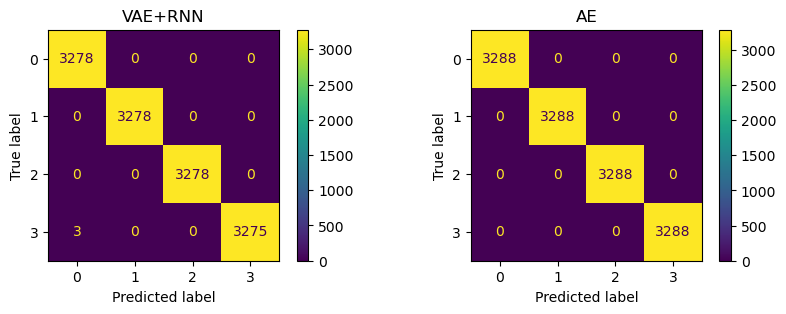

ROC Curve:


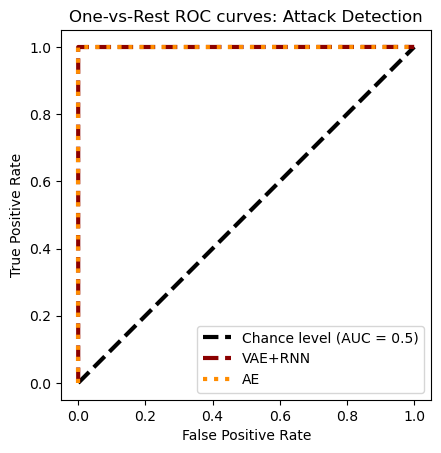

In [18]:
severity = 8
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.998173  1.000000  0.999086      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999389  0.998170  0.998779      3278

    accuracy                       0.999390     13112
   macro avg   0.999391  0.999390  0.999390     13112
weighted avg   0.999391  0.999390  0.999390     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


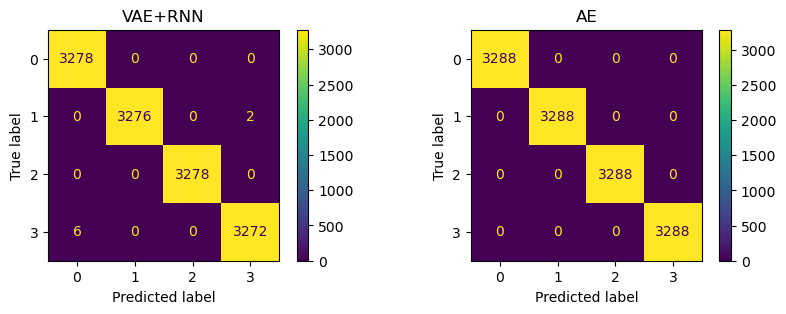

ROC Curve:


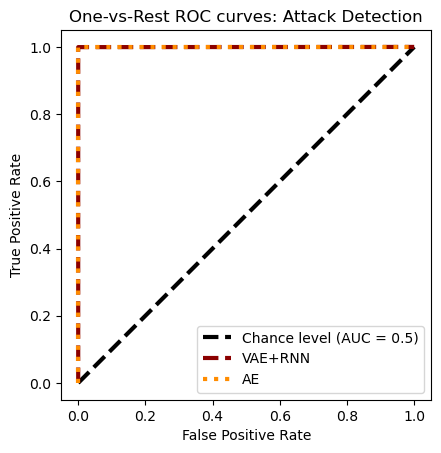

In [19]:
severity = 9
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 5%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999086  1.000000  0.999543      3278
           1   1.000000  0.999085  0.999542      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999696  0.998783  0.999239      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.997573  1.000000  0.998785      3288
           3   0.998782  0.997871  0.998326      3288

    accuracy                       0.999012     13152
   macro avg   0.999013  0.999012  0.999012     13152
weighted avg   0.999013  0.999012  0.999012     13152

Confusion Matrix:


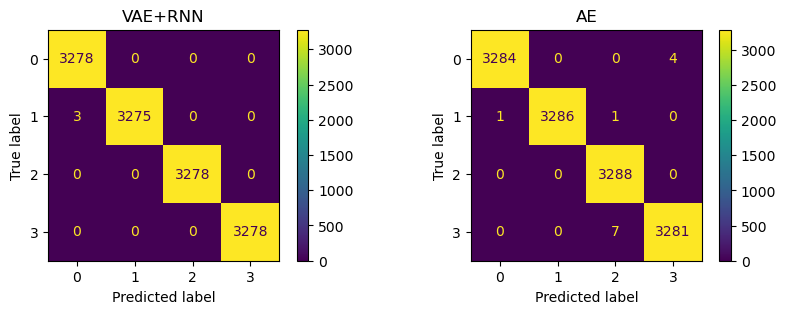

ROC Curve:


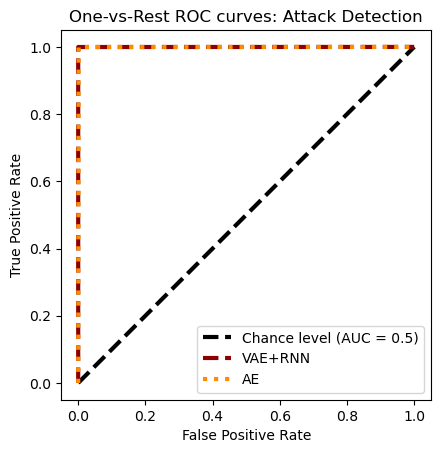

In [20]:
severity = 5
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       1.000000     13112
   macro avg   1.000000  1.000000  1.000000     13112
weighted avg   1.000000  1.000000  1.000000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.998783  0.999391      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.998785  1.000000  0.999392      3288
           3   0.998783  0.998783  0.998783      3288

    accuracy                       0.999392     13152
   macro avg   0.999392  0.999392  0.999392     13152
weighted avg   0.999392  0.999392  0.999392     13152

Confusion Matrix:


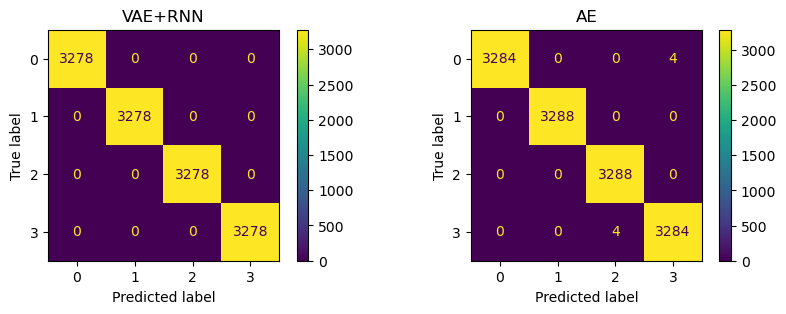

ROC Curve:


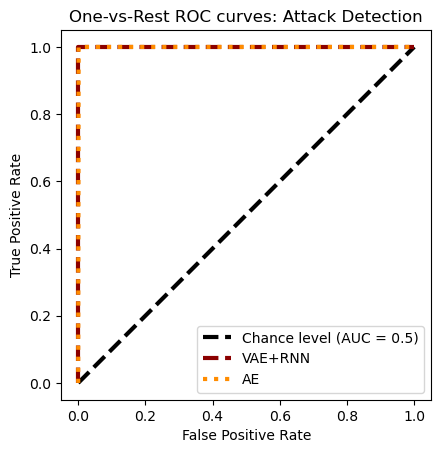

In [21]:
severity = 6
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.999390  0.999695      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.998783  0.999391      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.998785  1.000000  0.999392      3288
           3   0.998783  0.998783  0.998783      3288

    accuracy                       0.999392     13152
   macro avg   0.999392  0.999392  0.999392     13152
weighted avg   0.999392  0.999392  0.999392     13152

Confusion Matrix:


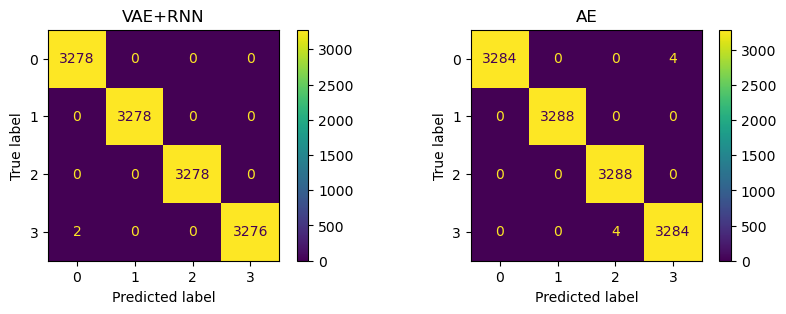

ROC Curve:


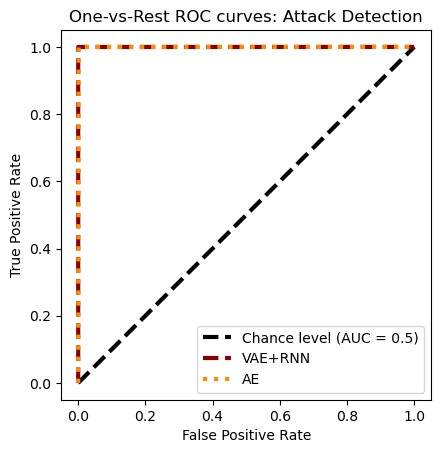

In [22]:
severity = 7
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.998173  1.000000  0.999086      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.998170  0.999084      3278

    accuracy                       0.999542     13112
   macro avg   0.999543  0.999542  0.999542     13112
weighted avg   0.999543  0.999542  0.999542     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.994850  0.998783  0.996813      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.998785  1.000000  0.999392      3288
           3   0.998777  0.993613  0.996188      3288

    accuracy                       0.998099     13152
   macro avg   0.998103  0.998099  0.998098     13152
weighted avg   0.998103  0.998099  0.998098     13152

Confusion Matrix:


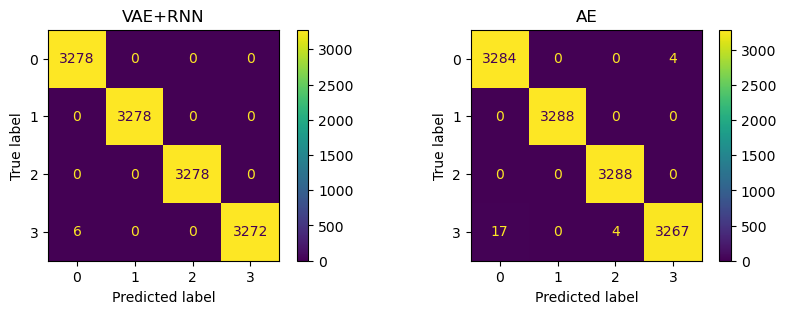

ROC Curve:


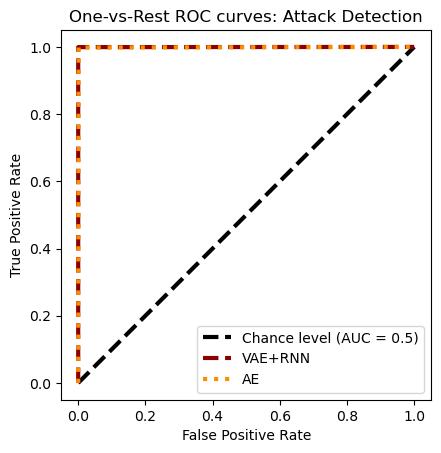

In [23]:
severity = 8
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.988839  1.000000  0.994388      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  0.999695  0.999847      3278
           3   0.999383  0.989018  0.994174      3278

    accuracy                       0.997026     13112
   macro avg   0.997056  0.997026  0.997026     13112
weighted avg   0.997056  0.997026  0.997026     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.953266  0.998783  0.975494      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.998754  0.975365  0.986921      3288
           3   0.973504  0.949818  0.961515      3288

    accuracy                       0.980991     13152
   macro avg   0.981381  0.980991  0.980982     13152
weighted avg   0.981381  0.980991  0.980982     13152

Confusion Matrix:


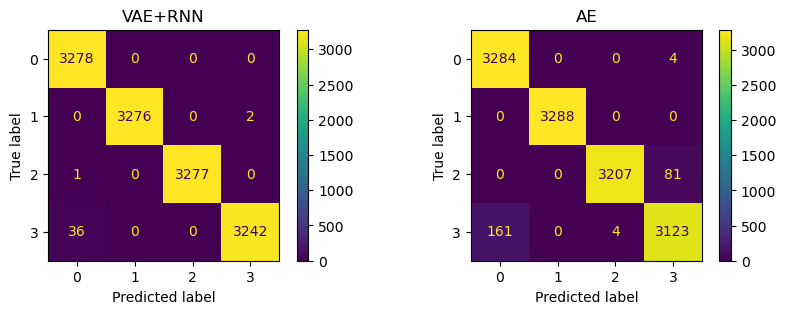

ROC Curve:


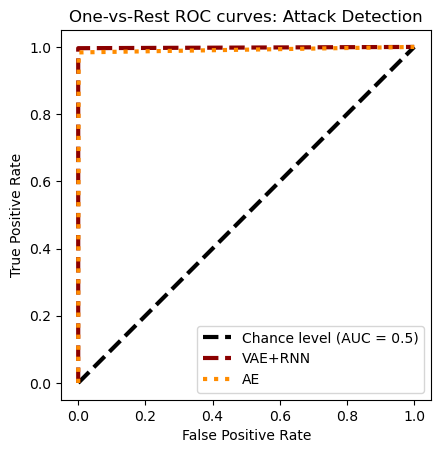

In [24]:
severity = 9
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 10%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999640  0.844282  0.915416      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.901316  1.000000  0.948097      3288
           3   0.851206  0.890815  0.870560      3288

    accuracy                       0.933622     13152
   macro avg   0.938040  0.933622  0.933442     13152
weighted avg   0.938040  0.933622  0.933442     13152

Confusion Matrix:


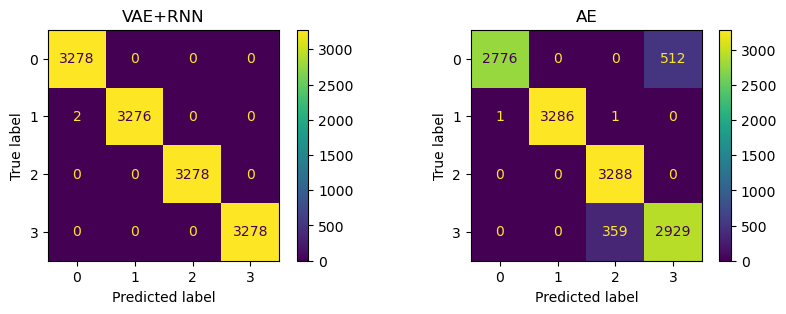

ROC Curve:


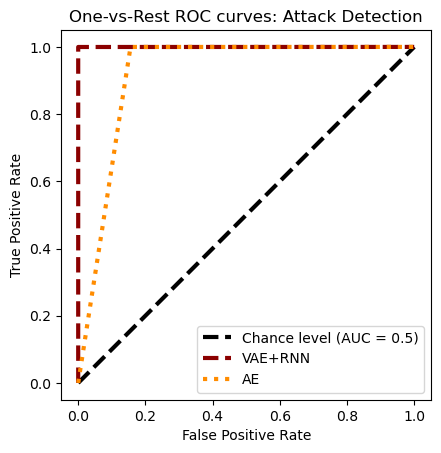

In [25]:
severity = 5
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       1.000000     13112
   macro avg   1.000000  1.000000  1.000000     13112
weighted avg   1.000000  1.000000  1.000000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.992137  0.844282  0.912258      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.942390  1.000000  0.970341      3288
           3   0.856863  0.932178  0.892935      3288

    accuracy                       0.944115     13152
   macro avg   0.947848  0.944115  0.943883     13152
weighted avg   0.947848  0.944115  0.943883     13152

Confusion Matrix:


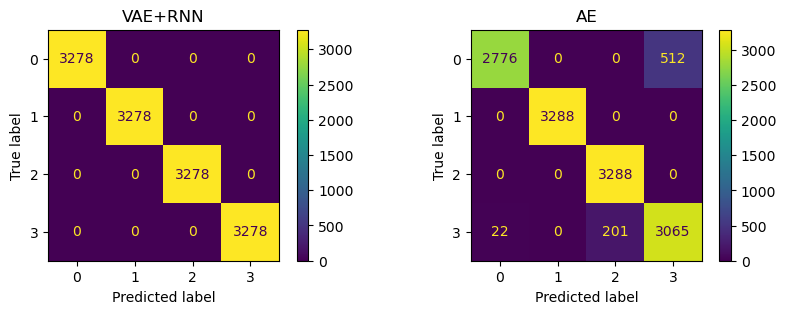

ROC Curve:


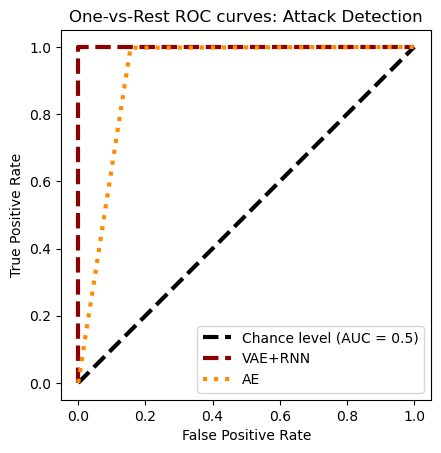

In [26]:
severity = 6
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999086  1.000000  0.999543      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.999085  0.999542      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.914964  0.844282  0.878203      3288
           1   0.999696  1.000000  0.999848      3288
           2   0.964789  1.000000  0.982079      3288
           3   0.850336  0.884732  0.867193      3288

    accuracy                       0.932254     13152
   macro avg   0.932446  0.932254  0.931831     13152
weighted avg   0.932446  0.932254  0.931831     13152

Confusion Matrix:


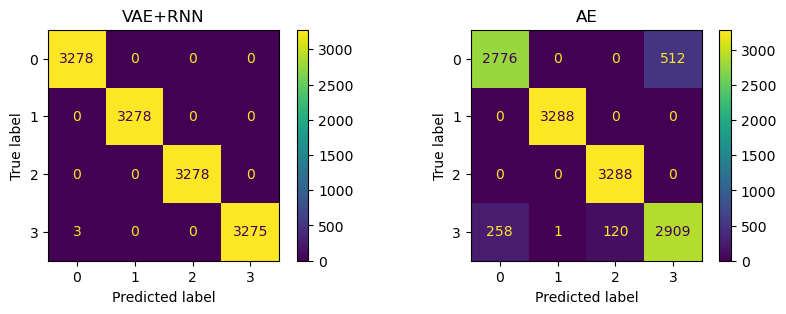

ROC Curve:


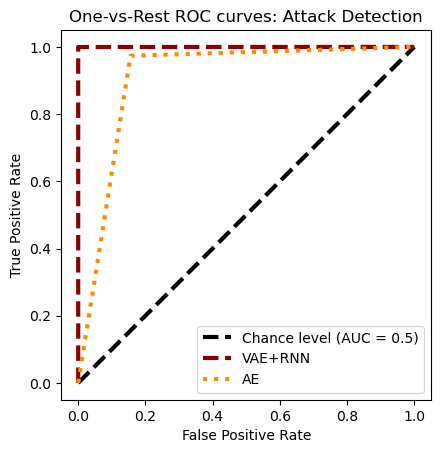

In [27]:
severity = 7
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.993936  1.000000  0.996959      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.993899  0.996940      3278

    accuracy                       0.998475     13112
   macro avg   0.998484  0.998475  0.998475     13112
weighted avg   0.998484  0.998475  0.998475     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.777156  0.844282  0.809329      3288
           1   0.998179  1.000000  0.999088      3288
           2   0.978571  1.000000  0.989170      3288
           3   0.825017  0.734185  0.776955      3288

    accuracy                       0.894617     13152
   macro avg   0.894731  0.894617  0.893636     13152
weighted avg   0.894731  0.894617  0.893636     13152

Confusion Matrix:


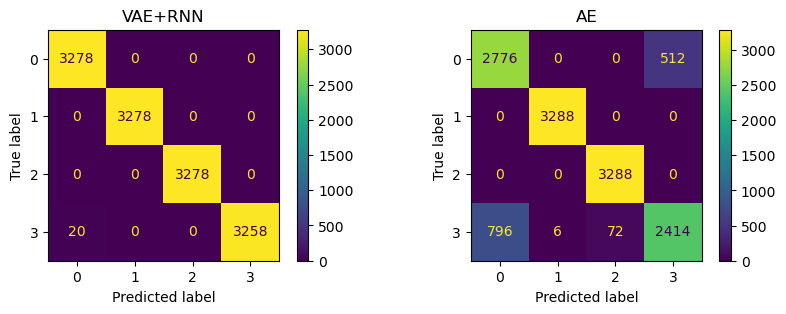

ROC Curve:


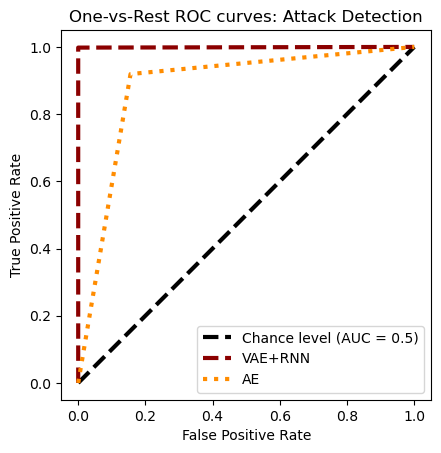

In [28]:
severity = 8
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.946578  1.000000  0.972556      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  0.999695  0.999847      3278
           3   0.999354  0.943868  0.970819      3278

    accuracy                       0.985738     13112
   macro avg   0.986483  0.985738  0.985729     13112
weighted avg   0.986483  0.985738  0.985729     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.665707  0.844282  0.744436      3288
           1   0.994251  0.946776  0.969933      3288
           2   0.971808  0.712895  0.822456      3288
           3   0.549288  0.574513  0.561617      3288

    accuracy                       0.769617     13152
   macro avg   0.795263  0.769617  0.774611     13152
weighted avg   0.795263  0.769617  0.774611     13152

Confusion Matrix:


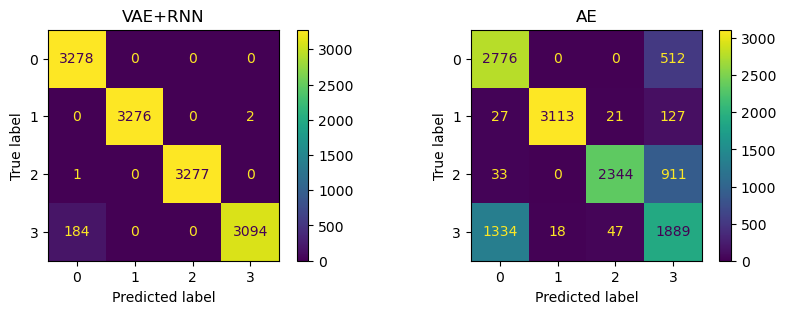

ROC Curve:


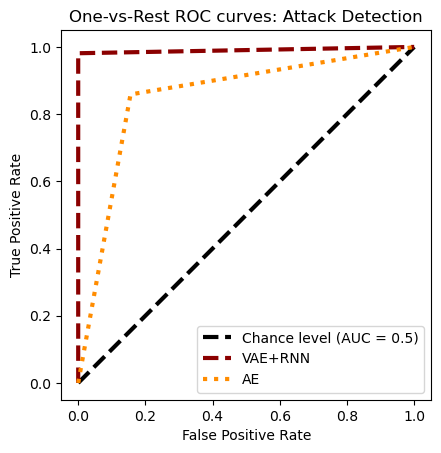

In [29]:
severity = 9
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 20%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.975904  0.960766  0.968276      3288
           1   0.951636  0.999392  0.974930      3288
           2   0.983548  1.000000  0.991706      3288
           3   0.979481  0.929136  0.953644      3288

    accuracy                       0.972324     13152
   macro avg   0.972642  0.972324  0.972139     13152
weighted avg   0.972642  0.972324  0.972139     13152

Confusion Matrix:


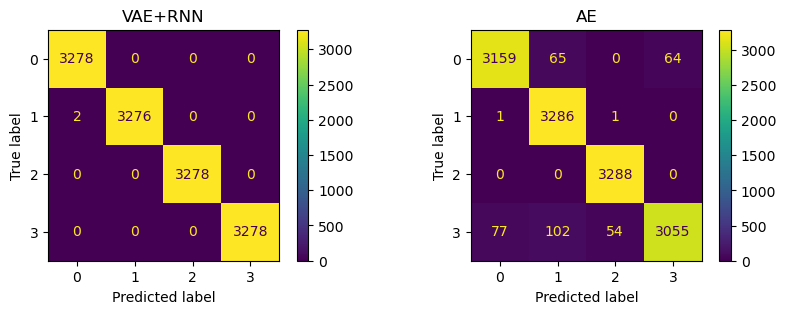

ROC Curve:


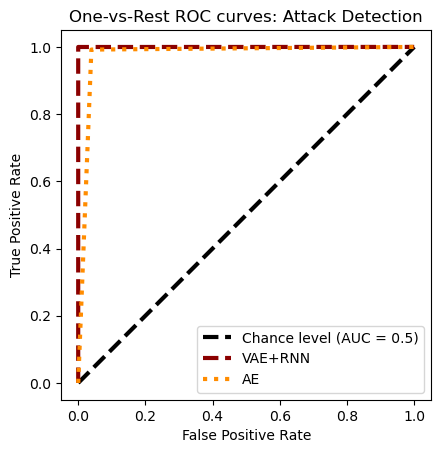

In [30]:
severity = 5
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       1.000000     13112
   macro avg   1.000000  1.000000  1.000000     13112
weighted avg   1.000000  1.000000  1.000000     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.856794  0.960766  0.905806      3288
           1   0.882922  1.000000  0.937821      3288
           2   0.990361  1.000000  0.995157      3288
           3   0.973565  0.716849  0.825714      3288

    accuracy                       0.919404     13152
   macro avg   0.925910  0.919404  0.916125     13152
weighted avg   0.925910  0.919404  0.916125     13152

Confusion Matrix:


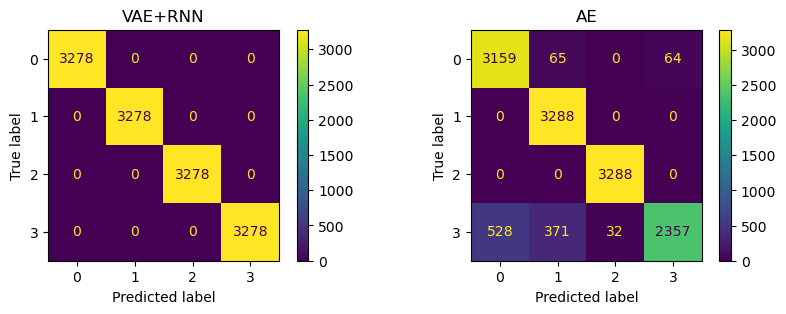

ROC Curve:


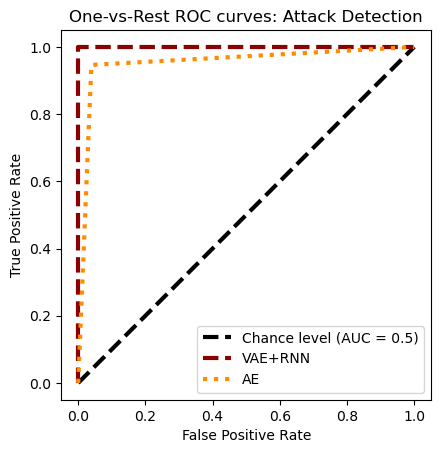

In [31]:
severity = 6
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.997262  1.000000  0.998629      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.997254  0.998625      3278

    accuracy                       0.999314     13112
   macro avg   0.999315  0.999314  0.999314     13112
weighted avg   0.999315  0.999314  0.999314     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.725540  0.960766  0.826747      3288
           1   0.761640  1.000000  0.864694      3288
           2   0.993654  1.000000  0.996817      3288
           3   0.945392  0.336983  0.496861      3288

    accuracy                       0.824437     13152
   macro avg   0.856556  0.824437  0.796280     13152
weighted avg   0.856556  0.824437  0.796280     13152

Confusion Matrix:


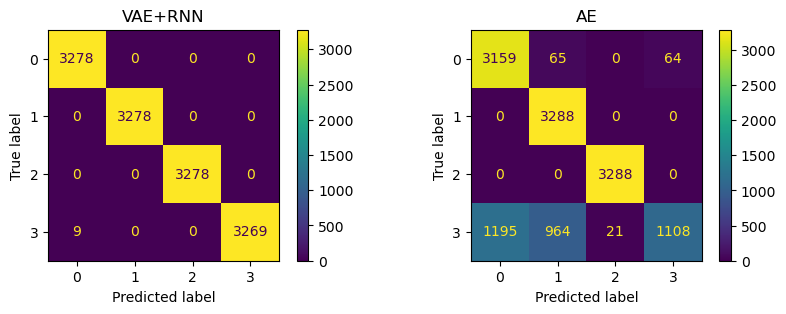

ROC Curve:


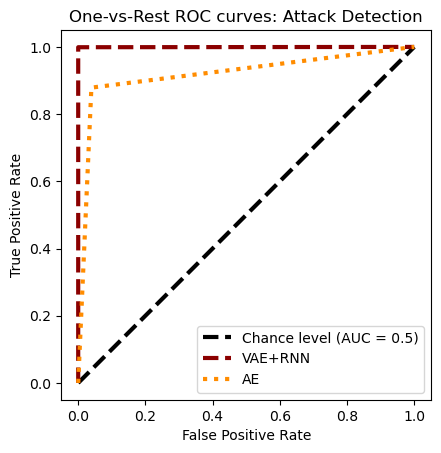

In [32]:
severity = 7
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.935769  1.000000  0.966819      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.931361  0.964461      3278

    accuracy                       0.982840     13112
   macro avg   0.983942  0.982840  0.982820     13112
weighted avg   0.983942  0.982840  0.982820     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.661571  0.960766  0.783579      3288
           1   0.753092  1.000000  0.859159      3288
           2   0.994855  0.999696  0.997269      3288
           3   0.908062  0.195255  0.321402      3288

    accuracy                       0.788929     13152
   macro avg   0.829395  0.788929  0.740352     13152
weighted avg   0.829395  0.788929  0.740352     13152

Confusion Matrix:


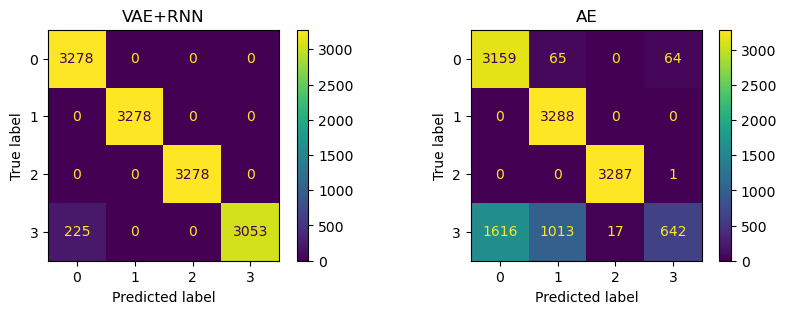

ROC Curve:


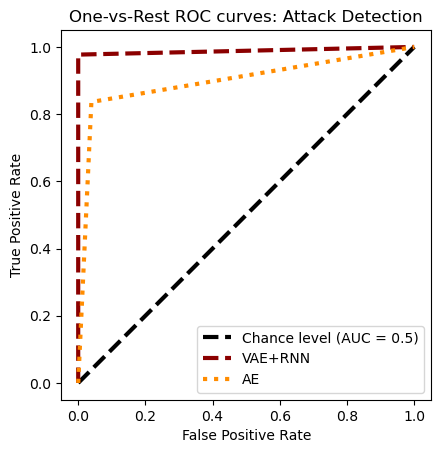

In [33]:
severity = 8
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.802252  1.000000  0.890277      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  0.999695  0.999847      3278
           3   0.999596  0.754118  0.859677      3278

    accuracy                       0.938301     13112
   macro avg   0.950462  0.938301  0.937374     13112
weighted avg   0.950462  0.938301  0.937374     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.598976  0.960766  0.737912      3288
           1   0.657306  0.982360  0.787613      3288
           2   0.983274  0.250304  0.399030      3288
           3   0.215797  0.139599  0.169529      3288

    accuracy                       0.583257     13152
   macro avg   0.613838  0.583257  0.523521     13152
weighted avg   0.613838  0.583257  0.523521     13152

Confusion Matrix:


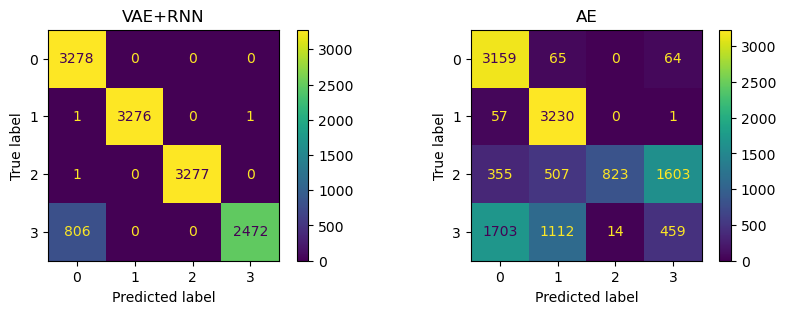

ROC Curve:


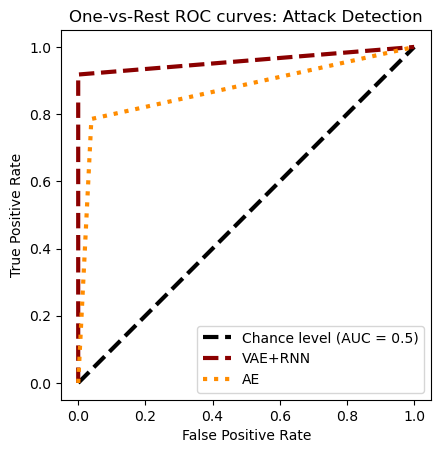

In [34]:
severity = 9
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 50%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999696  1.000000  0.999848      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.999696  1.000000  0.999848      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       0.999848     13152
   macro avg   0.999848  0.999848  0.999848     13152
weighted avg   0.999848  0.999848  0.999848     13152

Confusion Matrix:


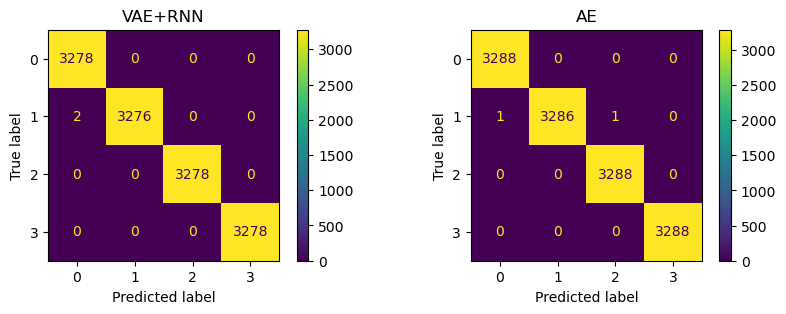

ROC Curve:


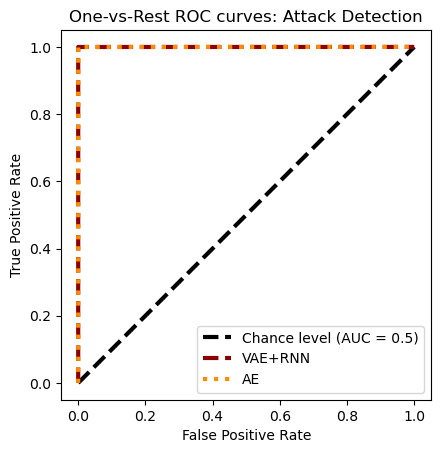

In [35]:
severity = 5
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.999390  0.999695      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.978571  1.000000  0.989170      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.978102  0.988930      3288

    accuracy                       0.994526     13152
   macro avg   0.994643  0.994526  0.994525     13152
weighted avg   0.994643  0.994526  0.994525     13152

Confusion Matrix:


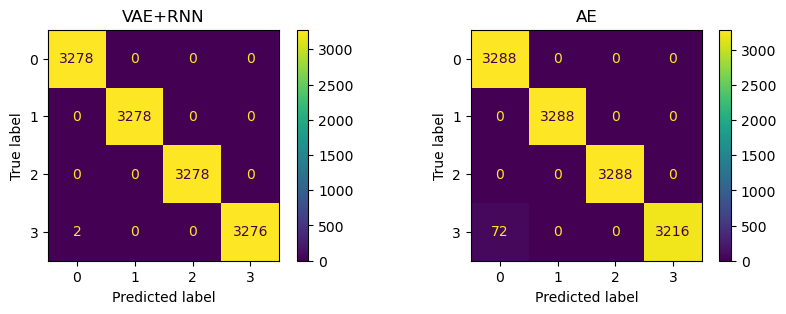

ROC Curve:


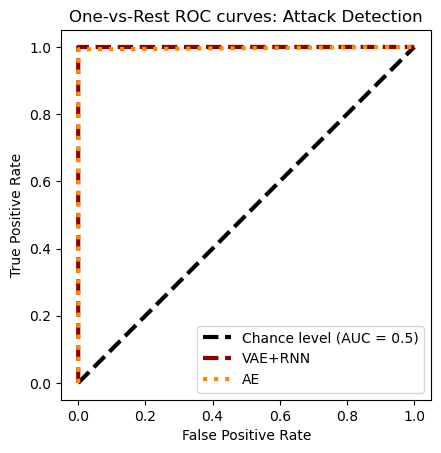

In [36]:
severity = 6
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.970684  1.000000  0.985124      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.969799  0.984668      3278

    accuracy                       0.992450     13112
   macro avg   0.992671  0.992450  0.992448     13112
weighted avg   0.992671  0.992450  0.992448     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.837280  1.000000  0.911435      3288
           1   0.999392  1.000000  0.999696      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.805049  0.891997      3288

    accuracy                       0.951262     13152
   macro avg   0.959168  0.951262  0.950782     13152
weighted avg   0.959168  0.951262  0.950782     13152

Confusion Matrix:


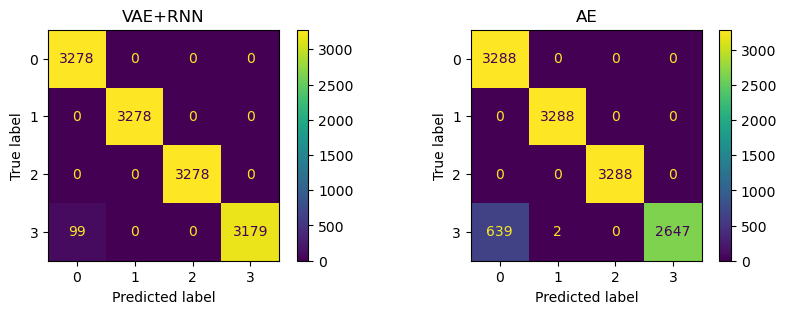

ROC Curve:


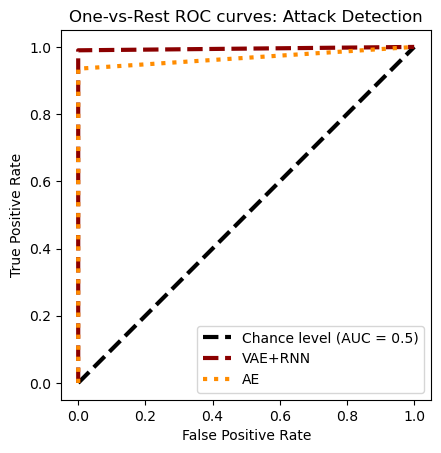

In [37]:
severity = 7
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.785338  1.000000  0.879764      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  0.726663  0.841696      3278

    accuracy                       0.931666     13112
   macro avg   0.946334  0.931666  0.930365     13112
weighted avg   0.946334  0.931666  0.930365     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.585783  1.000000  0.738793      3288
           1   1.000000  0.861010  0.925315      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.431873  0.603229      3288

    accuracy                       0.823221     13152
   macro avg   0.896446  0.823221  0.816834     13152
weighted avg   0.896446  0.823221  0.816834     13152

Confusion Matrix:


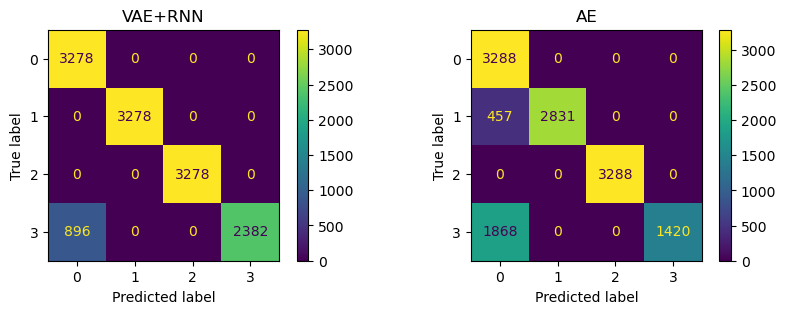

ROC Curve:


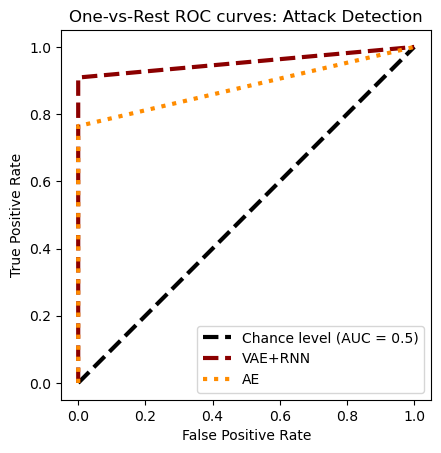

In [38]:
severity = 8
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.
classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.651949  1.000000  0.789309      3278
           1   1.000000  0.998780  0.999389      3278
           2   1.000000  0.994814  0.997400      3278
           3   0.998709  0.471934  0.640978      3278

    accuracy                       0.866382     13112
   macro avg   0.912664  0.866382  0.856769     13112
weighted avg   0.912664  0.866382  0.856769     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.360922  1.000000  0.530408      3288
           1   0.990291  0.062044  0.116772      3288
           2   1.000000  0.336375  0.503414      3288
           3   0.189377  0.157238  0.171818      3288

    accuracy                       0.388914     13152
   macro avg   0.635148  0.388914  0.330603     13152
weighted avg   0.635148  0.388914  0.330603     13152

Confusion Matrix:


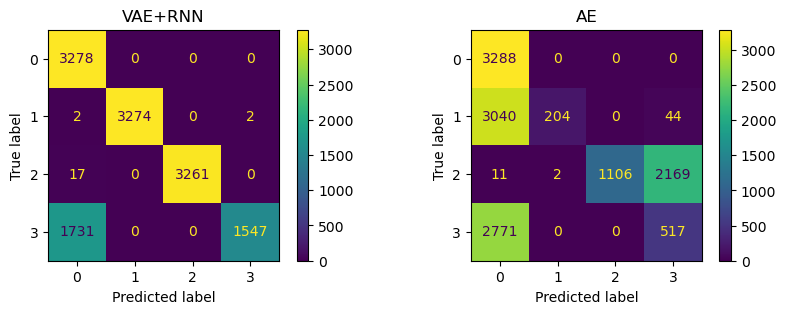

ROC Curve:


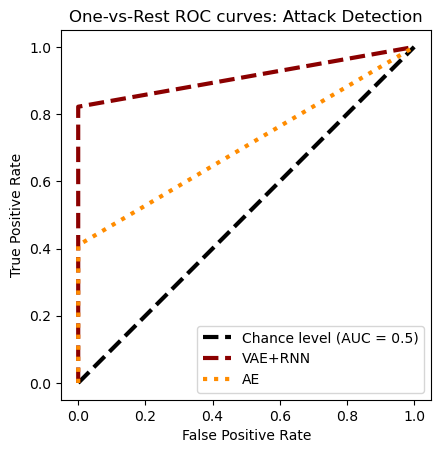

In [39]:
severity = 9
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}%_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

## **Quantiles**

In [40]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [41]:
severity = 5
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 41.43it/s]


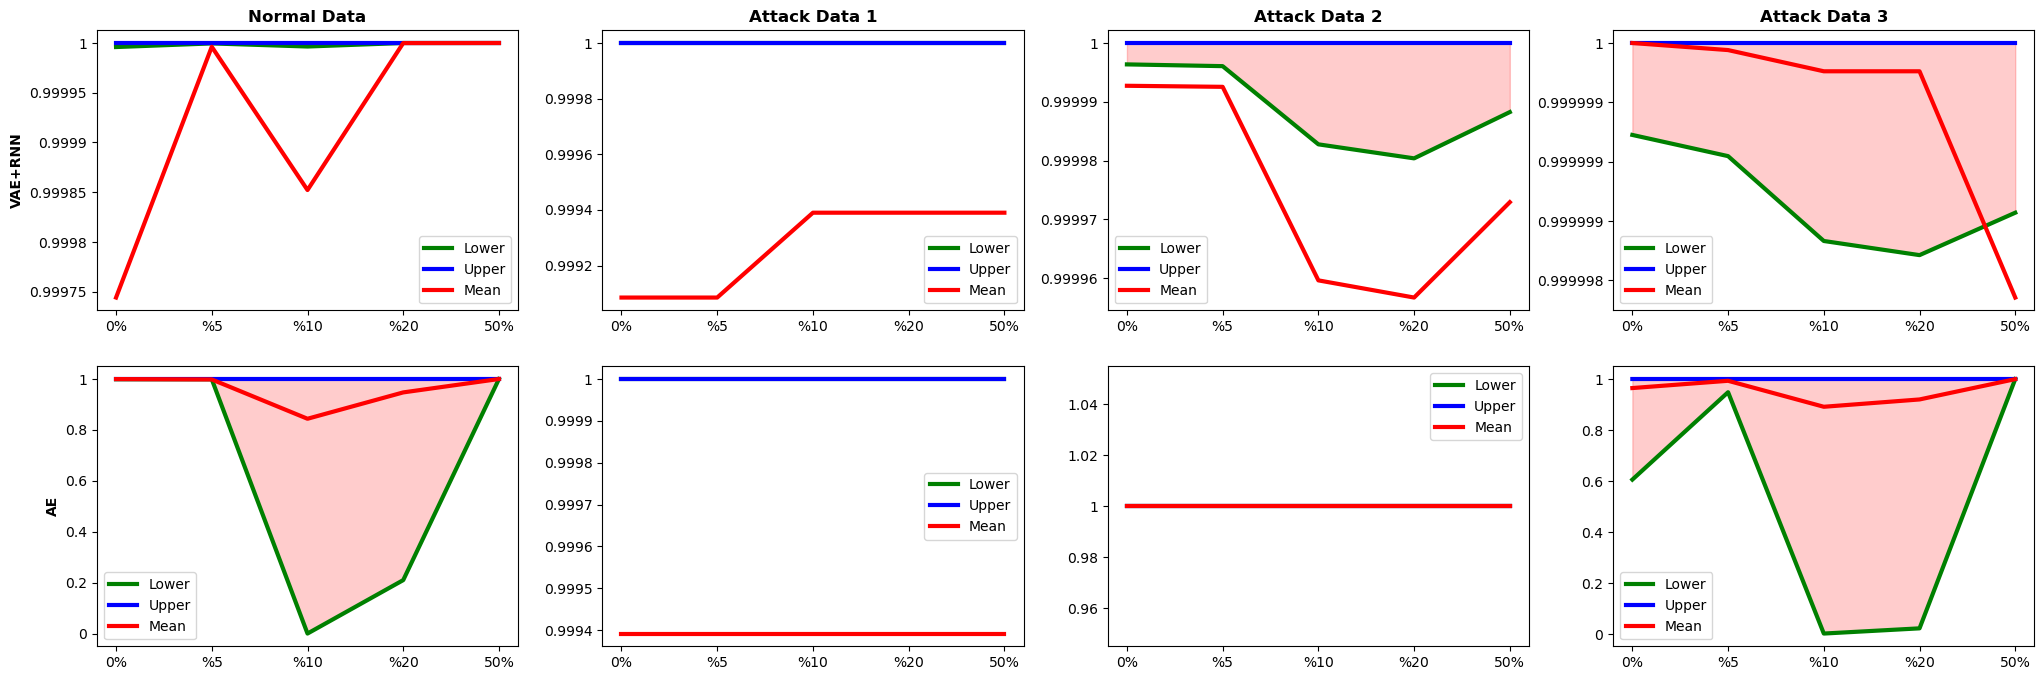

In [42]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 6**

In [43]:
severity = 6
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 38.85it/s]


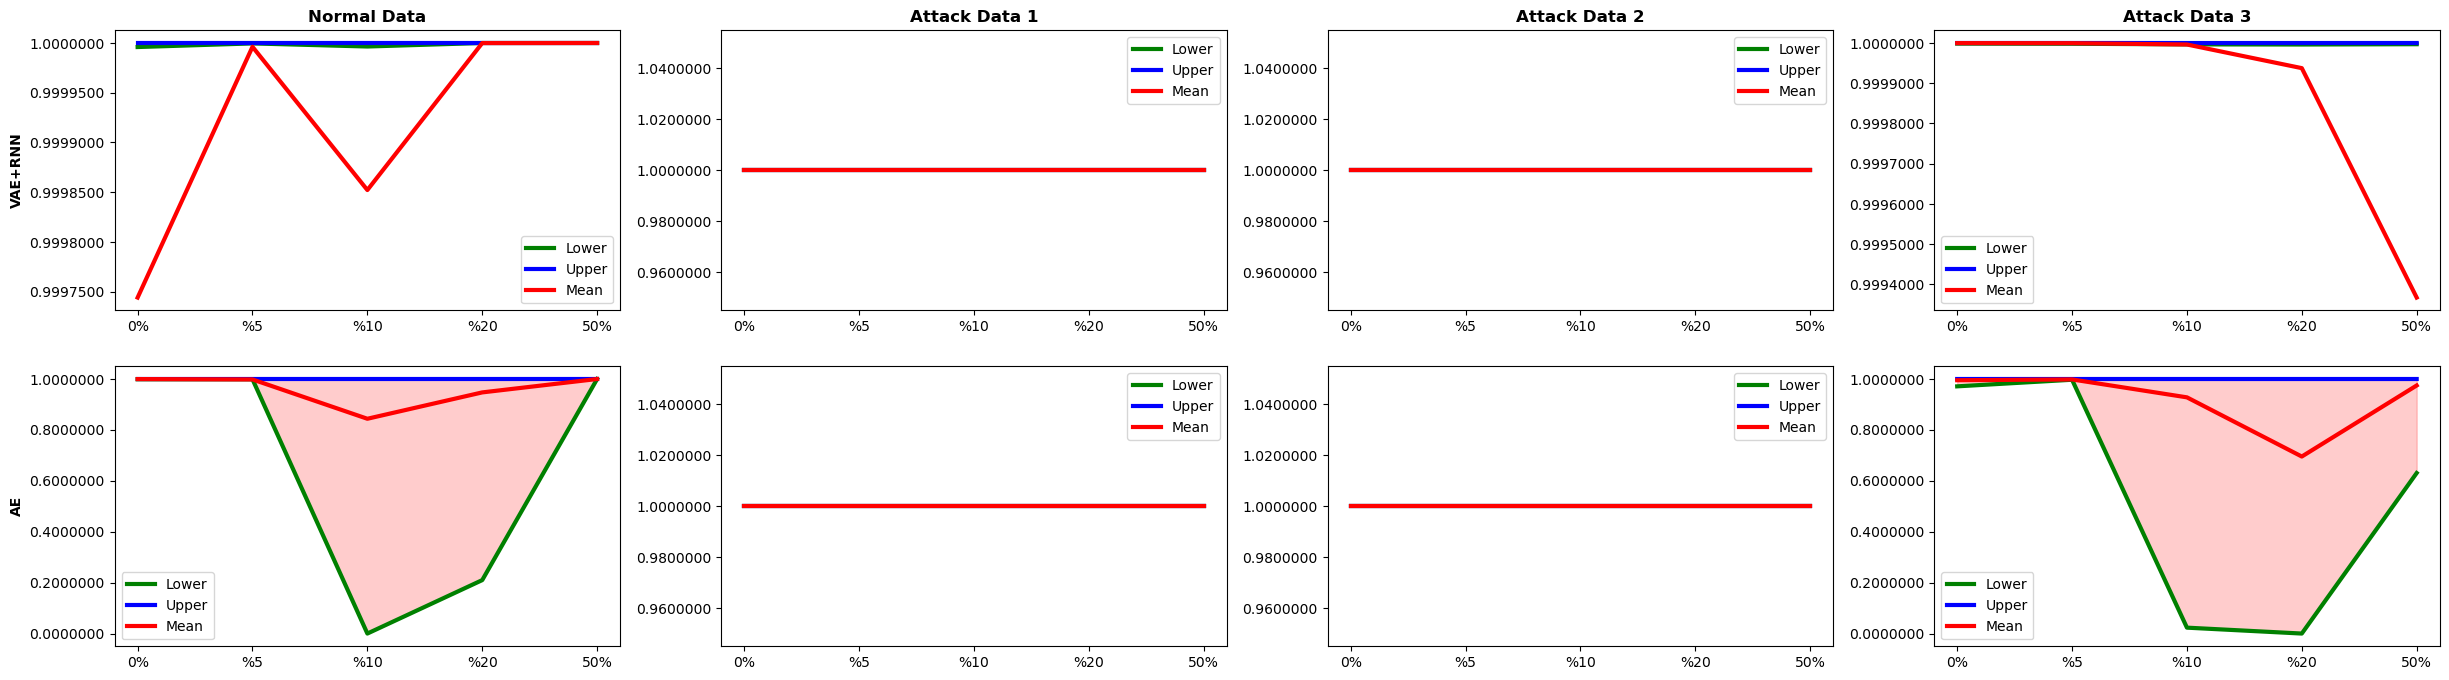

In [44]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.7f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 7**

In [45]:
severity = 7
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 36.45it/s]


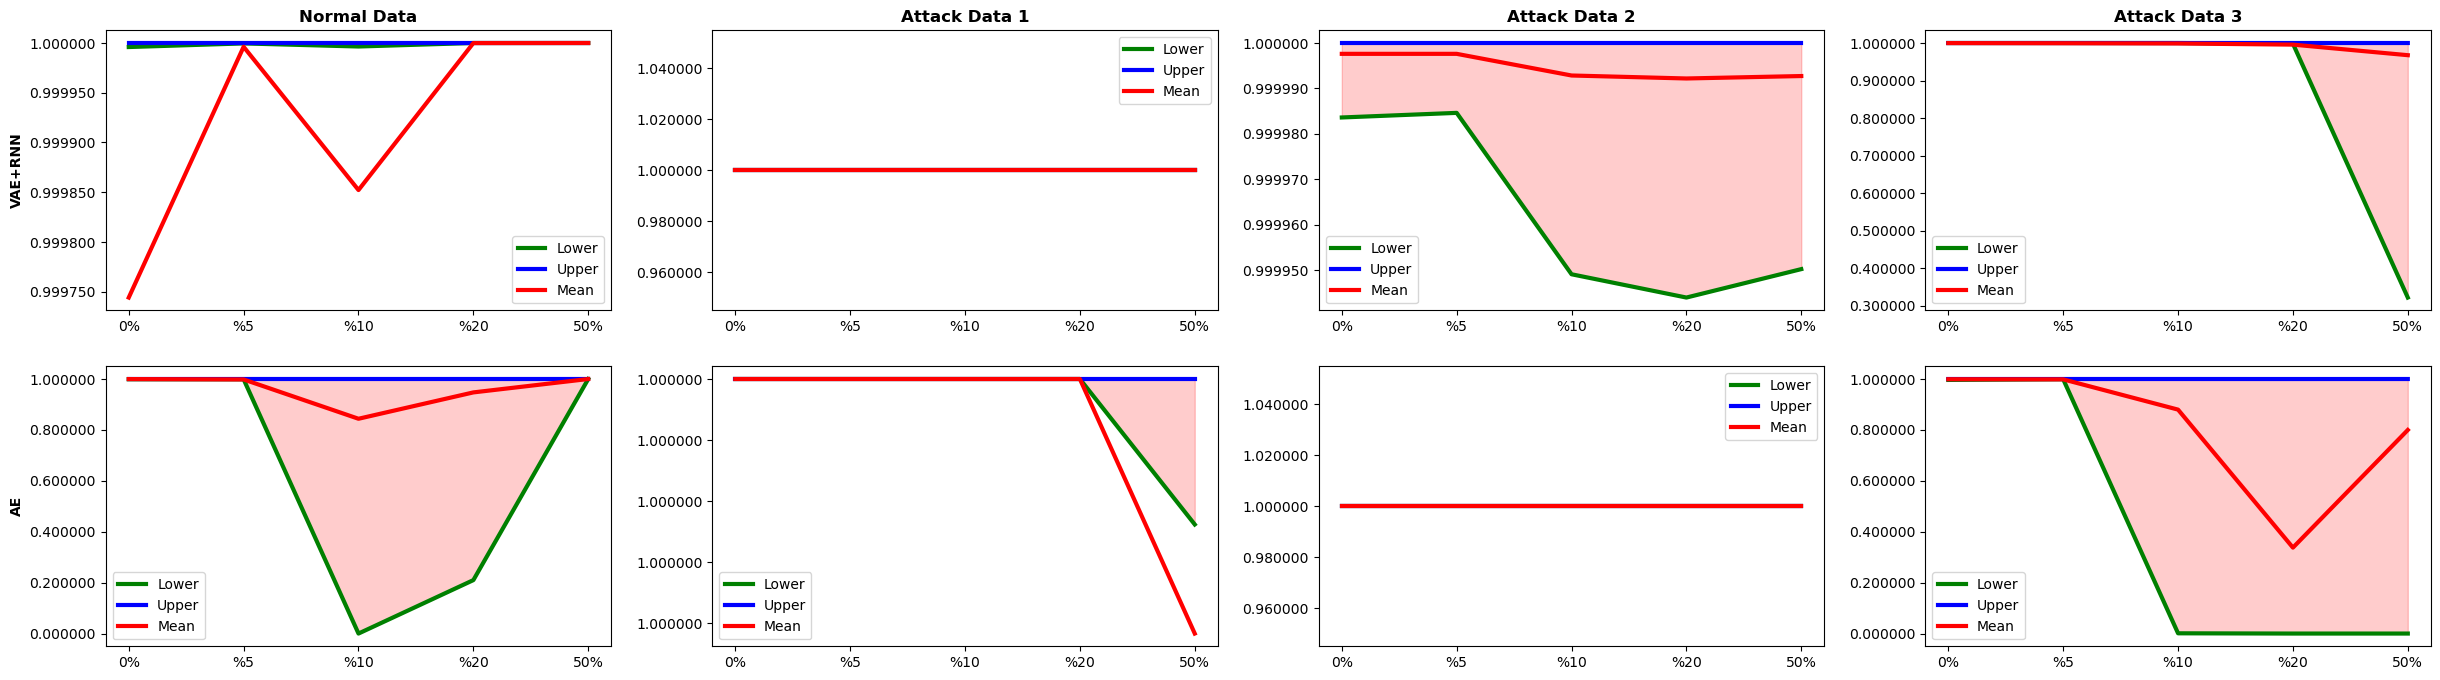

In [46]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.6f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 8**

In [47]:
severity = 8
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 22.58it/s]


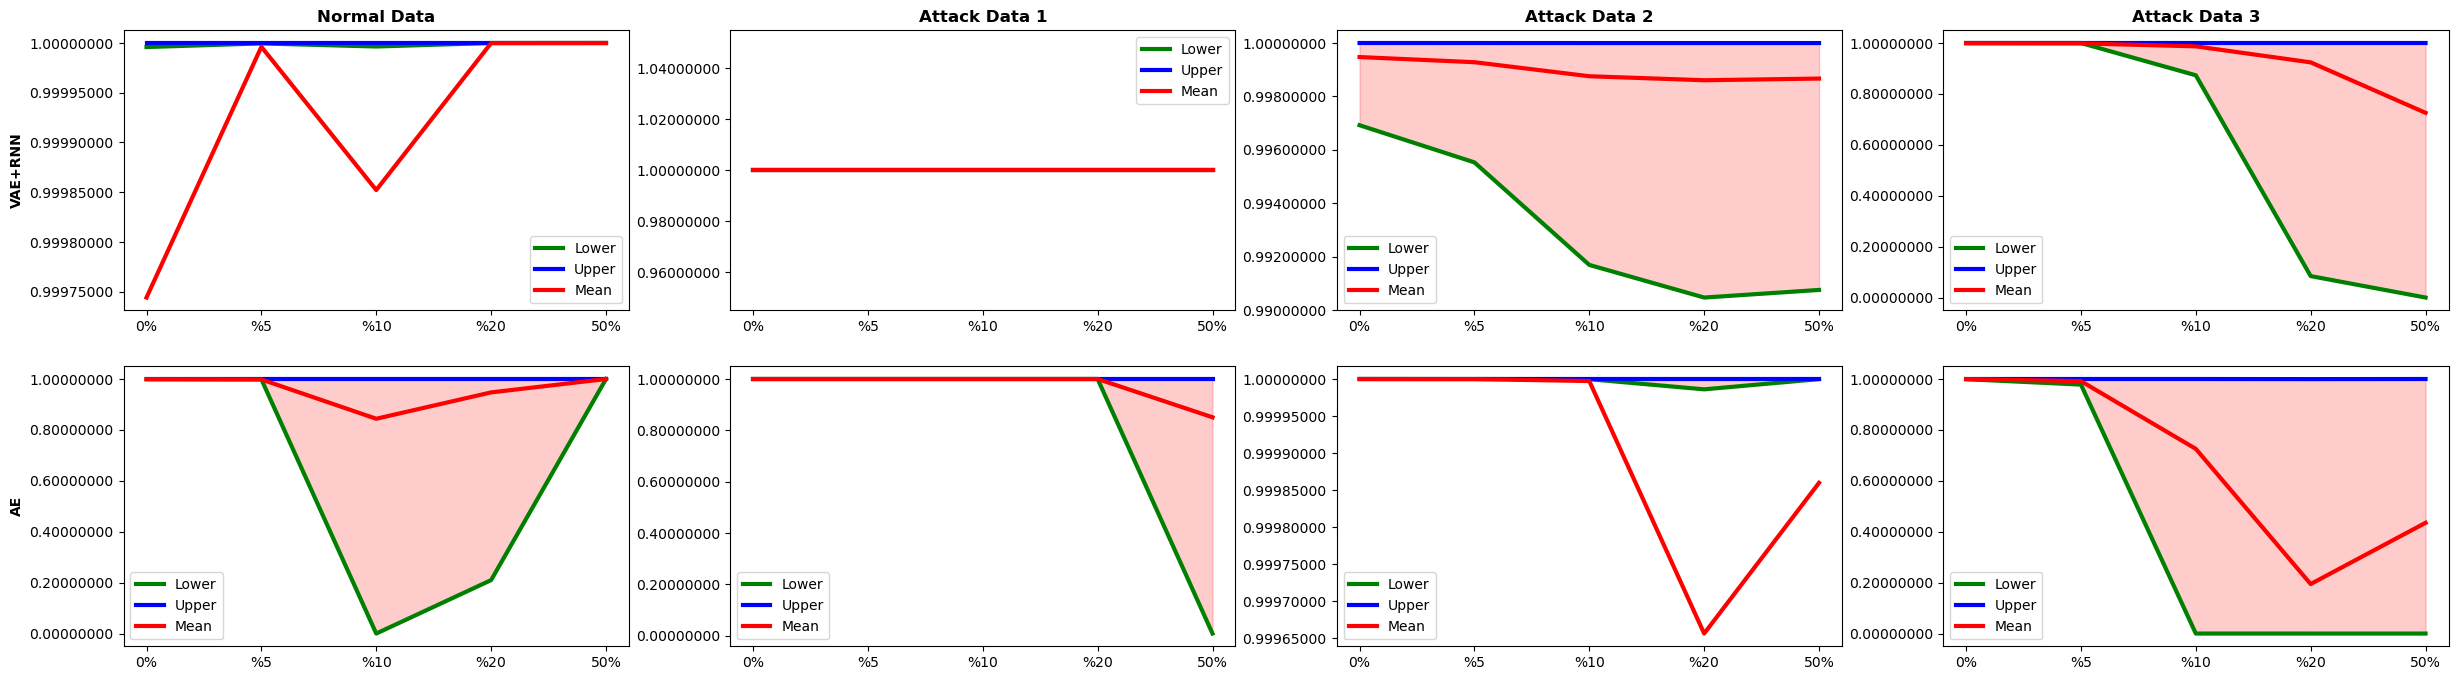

In [48]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.8f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 9**

In [49]:
severity = 9
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 15.35it/s]


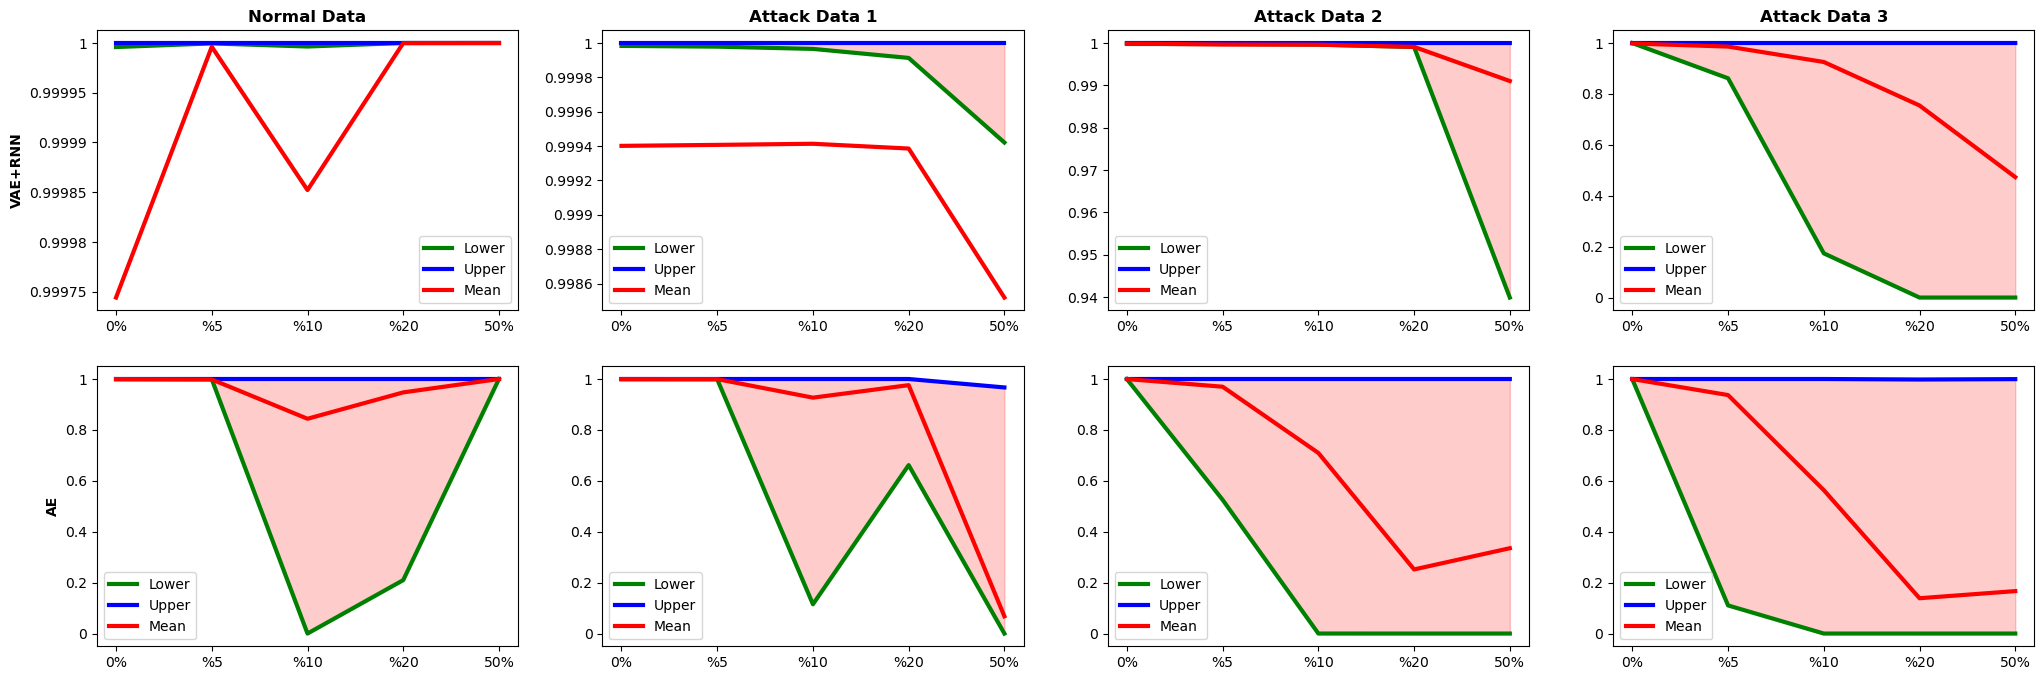

In [50]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## **Detection-Localozation Accuracy**

In [51]:
detection, localization = defaultdict(list), defaultdict(list)
for k in pred.keys():
    for severity in range(5,10):
        for level in noise_levels:
            pp = torch.argmax(pred[k][level,severity], dim=1).numpy()
            yy = torch.argmax(y[k], dim=1).numpy()
            localization[k, severity].append(metrics.accuracy_score(yy, pp))
            yy[yy>0] = 1
            pp[pp>0] = 1
            detection[k, severity].append(metrics.accuracy_score(yy,pp))

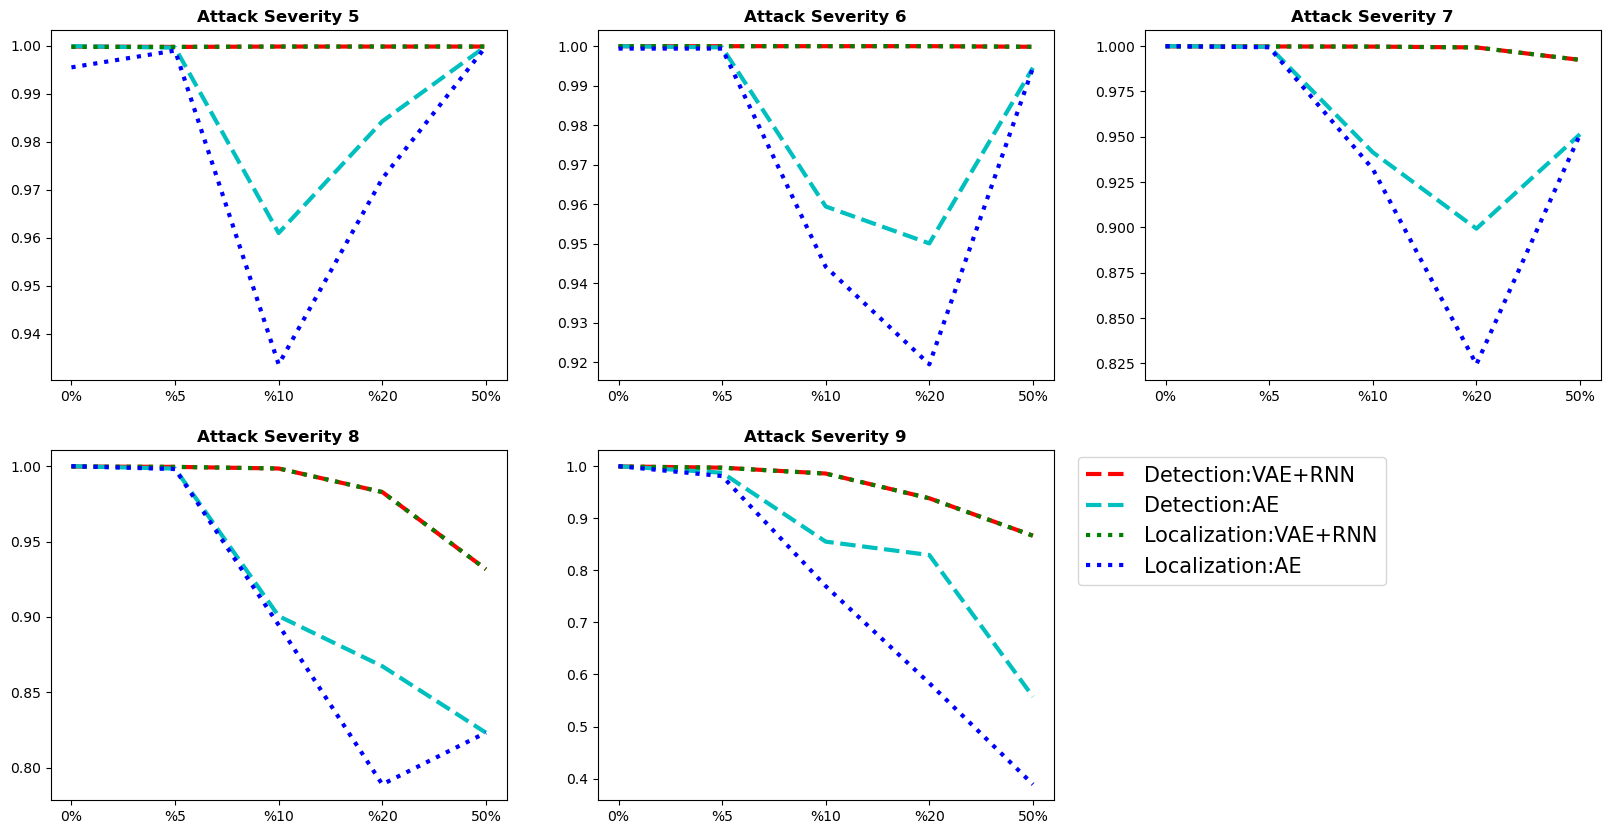

In [52]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, detection['vae',s], label='Detection:VAE+RNN', lw=3, linestyle="dashed", color='r')
    ax[i,s-5-j].plot(x, detection['ae',s], label='Detection:AE', lw=3, linestyle='dashed', color='c')
    ax[i,s-5-j].plot(x, localization['vae',s], label='Localization:VAE+RNN', lw=3, linestyle=":", color='g')
    ax[i,s-5-j].plot(x, localization['ae',s], label='Localization:AE', lw=3, linestyle=':', color='b')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.savefig('./img/d-l.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()